**This notebook shows an encoder-decoder model for Grammatical Error Correction. The following notebook was based on [Ben Trevett’s seq2seq tutorial](https://github.com/bentrevett/pytorch-seq2seq/). The main modification is to adapt the model from machine translation to grammatical error correction.**

Change current working directory to Google drive to access necessary files.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importing necessary libraries

In [ ]:
import os
PATH = r"/content/gdrive/My Drive/Colab Notebooks/gec_bea_2024"
os.chdir(PATH)

## Customized preprocessor

m2_data_preprocessor.py contains a customized class to preprocess m2 files from the BEA 2019 challenge.

In [ ]:
from m2_data_preprocessor import DataPreprocessor

Installing and importing necessary libraries.

In [ ]:
# !pip install torchtext==0.17.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext.vocab
import tqdm

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
print(torch.__version__)
print(torchtext.__version__)

2.3.0+cu121
0.18.0+cpu


In [ ]:
available_gpu = torch.cuda.is_available()
if available_gpu:
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU not available.")

GPU is available: Tesla T4


Setting seeds for reproducibility

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
reverse = False  # If True, source tokens are used in reverse for training: Consider (Sutskever et al. 2014)

#Data

Setting paths for data preprocessing

In [ ]:
# File names from BEA 2019

A_train = "A.train.gold.bea19.m2"
B_train = "B.train.gold.bea19.m2"
C_train = "C.train.gold.bea19.m2"

A_dev = "A.dev.gold.bea19.m2"
B_dev = "B.dev.gold.bea19.m2"
C_dev = "C.dev.gold.bea19.m2"

training_raw_data = [A_train, B_train, C_train]
validation_raw_data = [A_dev, B_dev, C_dev]

N_test = "N.dev.gold.bea19.m2"

# Path to data of current project

hard_path = "data/m2/"

Preprocessing training data


In [ ]:
preprocessor_training = DataPreprocessor()

for file in training_raw_data:
  preprocessor_training.read_m2_data(hard_path + file)

print(len(preprocessor_training.data))
print(preprocessor_training.data[15:20])

train_data = preprocessor_training.data

68326
[{'src': 'Finally , I will have high salary when I am Journalist .', 'tgt': 'Finally , I will have a high salary when I am a journalist .'}, {'src': "To be Journalist , I must study very hard so I 'll try to learn in order to make my dream comes true .", 'tgt': "To be a journalist , I must study very hard , so I 'll try to learn in order to make my dream come true ."}, {'src': "In the future , I 'll become a journalist .", 'tgt': "In the future , I 'll become a journalist ."}, {'src': 'Now days each family has more then 1 car for each one , this is only one of few reason that people use less public transport .', 'tgt': 'Nowadays , each family has more than 1 car for each person , this is only one of several reasons why people use less public transport .'}, {'src': 'Before was really convenient to go by bus or by train but with the new economy the travel tickets are more expensive and a big difference from the past is that it is less expensive to go far then near .', 'tgt': 'Befor

Enlarge training data with more examples of correct sentences.

In [ ]:
train_data_only_correct = []

for element in train_data:
  element["tgt"]

  train_data_only_correct.append({"src": element["tgt"], "tgt": element["tgt"]})

print(len(train_data_only_correct))
print(train_data_only_correct[15:20])

train_data = train_data + train_data_only_correct

print(len(train_data))

68326
[{'src': 'Finally , I will have a high salary when I am a journalist .', 'tgt': 'Finally , I will have a high salary when I am a journalist .'}, {'src': "To be a journalist , I must study very hard , so I 'll try to learn in order to make my dream come true .", 'tgt': "To be a journalist , I must study very hard , so I 'll try to learn in order to make my dream come true ."}, {'src': "In the future , I 'll become a journalist .", 'tgt': "In the future , I 'll become a journalist ."}, {'src': 'Nowadays , each family has more than 1 car for each person , this is only one of several reasons why people use less public transport .', 'tgt': 'Nowadays , each family has more than 1 car for each person , this is only one of several reasons why people use less public transport .'}, {'src': 'Before , it was really convenient to go by bus or by train , but with the new economy , the fares are more expensive and a big difference from the past is that it is less expensive to go long - distance

Preprocessing validation data

In [ ]:
preprocessor_val = DataPreprocessor()

for file in validation_raw_data:
  preprocessor_val.read_m2_data(hard_path + file)

print(len(preprocessor_val.data))
print(preprocessor_val.data[5:10])

val_data = preprocessor_val.data

6760
[{'src': 'I think that the public transport will always be in the future .', 'tgt': 'I think that public transport will always exist in the future .'}, {'src': 'The rich people will buy a car but the poor people always need to use a bus or taxi .', 'tgt': 'Rich people will buy a car , but poor people always need to use a bus or taxi .'}, {'src': 'I consider that is more convenient to drive a car because you carry on more things in your own car than travelling by car .', 'tgt': 'I consider it more convenient to drive a car , because you carry more things in your own car than when travelling by car .'}, {'src': "Also , you 'll meet friendly people who usually ask to you something to be friends and change your telephone number .", 'tgt': "Also , you 'll meet friendly people who usually ask you to be friends and exchange telephone numbers ."}, {'src': "In my experience when I did n't have a car I used to use the bus to go to the school and go back to my house .", 'tgt': "In my experie

Preparing test data

In [ ]:
preprocessor_test = DataPreprocessor()

preprocessor_test.read_m2_data(hard_path + N_test)

print(len(preprocessor_test.data))
print(preprocessor_test.data[0:5])

test_data = preprocessor_test.data

988
[{'src': 'Boxing is a common , well known and well loved sport amongst most countries in the world however it is also punishing , dangerous and disliked to the extent that many people want it banned , possibly with good reason .', 'tgt': 'Boxing is a common , well - known and well - loved sport in most countries in the world . However , it is also punishing , dangerous and disliked to the extent that many people want it banned , possibly with good reason .'}, {'src': 'Boxing is a dangerous sport , there are relatively common deaths , tragic injuries and even disease .', 'tgt': 'Boxing is a dangerous sport . There are relatively common deaths , tragic injuries and even disease .'}, {'src': 'All professional boxers are at risk from being killed in his next fight .', 'tgt': 'All professional boxers are at risk from being killed in their next fight .'}, {'src': 'If not killed then more likely paralysed .', 'tgt': 'If not killed , then more likely paralysed .'}, {'src': 'There have been

Trimming sentences and adding sos and eos tokens.

In [ ]:
def trim_sentences(input_dict, max_length, lower, reverse, sos_token, eos_token):

    src_tokens = [entry for entry in input_dict["src"].split()][:max_length]
    tgt_tokens = [entry for entry in input_dict["tgt"].split()][:max_length]

    if lower:
        src_tokens = [token.lower() for token in src_tokens]
        tgt_tokens = [token.lower() for token in tgt_tokens]

    if reverse:  # Reversing source sentence
      src_tokens = src_tokens[::-1]

    src_tokens = [sos_token] + src_tokens + [eos_token]
    tgt_tokens = [sos_token] + tgt_tokens + [eos_token]

    input_dict["src_tokens"] = src_tokens
    input_dict["tgt_tokens"] = tgt_tokens

    return input_dict

In [ ]:
max_length = 25
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

train_data = list(map(lambda x: trim_sentences(x, max_length, lower, reverse, sos_token,
                                               eos_token), train_data))

val_data = list(map(lambda x: trim_sentences(x, max_length, lower, reverse, sos_token,
                                             eos_token), val_data))

test_data = list(map(lambda x: trim_sentences(x, max_length, lower, reverse, sos_token,
                                              eos_token), test_data))

In [ ]:
train_data[30]

{'src': 'Do you know mountain biking ?',
 'tgt': 'Do you know about mountain biking ?',
 'src_tokens': ['<sos>',
  'do',
  'you',
  'know',
  'mountain',
  'biking',
  '?',
  '<eos>'],
 'tgt_tokens': ['<sos>',
  'do',
  'you',
  'know',
  'about',
  'mountain',
  'biking',
  '?',
  '<eos>']}

# Vocabularies

Each word will receive a number within the given vocabulary. Unknown words receive "unk" and are labeled with index 0.

The vocabulary is enriched with special tokens: *unk_token*, *sos_token*, *eos_token*, and *\<pad\>*.

In [ ]:
# Merging entries from training data to build rich vodabulary
train_data_src_list = [entry['src_tokens'] for entry in train_data]
train_data_tgt_list = [entry['tgt_tokens'] for entry in train_data]
train_data_list = train_data_src_list + train_data_tgt_list

In [ ]:
min_freq = 3
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
  unk_token,
  pad_token,
  sos_token,
  eos_token,
]

# Torch is building the vocabulary with indeces
en_vocab = torchtext.vocab.build_vocab_from_iterator(
  train_data_list,
  min_freq=min_freq,
  specials=special_tokens,
)

Testing vocabulary

In [ ]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', ',', 'the', 'to', 'and', 'i']

In [ ]:
en_vocab.get_itos()[9]

'i'

In [ ]:
en_vocab.get_stoi()["the"]

6

In [ ]:
en_vocab["the"]

6

In [ ]:
len(en_vocab) # With larger training data, e.g. by adding correct examples, the vocab increases -> because min_freq is now met more often

18925

Torch text does not automatically assign a value to *unk* and other specific tokens. Therefore, if a word is unknown so far no numerical value is returned.

In [ ]:
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]
en_vocab.set_default_index(unk_index)

In [ ]:
"The" in en_vocab

False

In [ ]:
en_vocab["The"]

0

Testing indices

In [ ]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[9, 129, 401, 2324, 586]

In [ ]:
def numericalize_example(input_dict, en_vocab):

  src_ids = en_vocab.lookup_indices(input_dict["src_tokens"])
  tgt_ids = en_vocab.lookup_indices(input_dict["tgt_tokens"])

  # Token ids are saved as torch tensors: See type(train_data[0]["src_ids"])
  input_dict["src_ids"] = torch.tensor(src_ids, dtype=torch.int64)
  input_dict["tgt_ids"] = torch.tensor(tgt_ids, dtype=torch.int64)

  return input_dict

In [ ]:
train_data = list(map(lambda x: numericalize_example(x, en_vocab), train_data))
val_data = list(map(lambda x: numericalize_example(x, en_vocab), val_data))
test_data = list(map(lambda x: numericalize_example(x, en_vocab), test_data))

In [ ]:
train_data[0]

{'src': 'My town is a medium size city with eighty thousand inhabitants .',
 'tgt': 'My town is a medium - sized city with eighty thousand inhabitants .',
 'src_tokens': ['<sos>',
  'my',
  'town',
  'is',
  'a',
  'medium',
  'size',
  'city',
  'with',
  'eighty',
  'thousand',
  'inhabitants',
  '.',
  '<eos>'],
 'tgt_tokens': ['<sos>',
  'my',
  'town',
  'is',
  'a',
  'medium',
  '-',
  'sized',
  'city',
  'with',
  'eighty',
  'thousand',
  'inhabitants',
  '.',
  '<eos>'],
 'src_ids': tensor([   2,   18,  185,   13,   10, 3108, 1602,  107,   23, 9432, 2150, 2490,
            4,    3]),
 'tgt_ids': tensor([   2,   18,  185,   13,   10, 3108,   67, 6965,  107,   23, 9432, 2150,
         2490,    4,    3])}

In [ ]:
type(train_data[0]["src_ids"])

torch.Tensor

#Data Loader

Data loader helps to combine the training instances into batches. For successful batches, padding is needed so that each batch has equal size.

"The `get_collate_fn` takes in the padding token index and returns the `collate_fn` defined inside it. This technique, of defining a function inside another and returning it, is known as a [closure](<https://en.wikipedia.org/wiki/Closure_(computer_programming)>). It allows the `collate_fn` to continually use the value of `pad_index` it was created with without creating a class or using global variables."

In [ ]:
def get_collate_fn(pad_index):

  def collate_fn(batch):

    batch_src_ids = [example["src_ids"] for example in batch]
    batch_tgt_ids = [example["tgt_ids"] for example in batch]
    batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
    batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)

    batch = {
      "src_ids": batch_src_ids,
      "tgt_ids": batch_tgt_ids,
    }

    return batch

  return collate_fn

Question: What happens when batches are being shuffled here? -- they are shuffled for training, but not for the validation and test sets.

Shuffling the training data can improve the stability of the training process and potentially enhance the model's overall performance. However, this step is only required for the training set. The metrics for the validation and test sets will remain consistent, regardless of the data order.

In [ ]:

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

  collate_fn = get_collate_fn(pad_index)

  data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=shuffle,
  ) # Try "pin_memory = True" / "num_workers = 2"

  return data_loader

Batch size should correspond to memory of GPU.

Question: How to find out about the current memory?

In [ ]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
val_data_loader = get_data_loader(val_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

#The model

The model has three parts: Encoder, Decoder, and seq2seq. All shall be implemented separately.

##1) Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):

    super().__init__() # Inherit boilerplate code from Torch

    self.hidden_dim = hidden_dim  # Dimension of one-hot vectors
    self.n_layers = n_layers  # Number of layers in LSTM network
    self.embedding = nn.Embedding(input_dim, embedding_dim)  # Converts one-hot vectors into lower dimension embeddings
    self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
    self.dropout = nn.Dropout(dropout)  # Regularization parameter

  def forward(self, src):  # src = [src length, batch size]

    embedded = self.dropout(self.embedding(src)) # embedded = [src length, batch size, embedding dim]

    outputs, (hidden, cell) = self.rnn(embedded)
    # outputs = [src length, batch size, hidden dim * n directions]
    # hidden = [n layers * n directions, batch size, hidden dim]
    # cell = [n layers * n directions, batch size, hidden dim]
    # outputs are always from the top hidden layer

    return hidden, cell

##2) Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):

    super().__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.embedding = nn.Embedding(output_dim, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
    self.fc_out = nn.Linear(hidden_dim, output_dim)  # Additional output layer for predictions
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    # input = [batch size]
    # hidden = [n layers * n directions, batch size, hidden dim]
    # cell = [n layers * n directions, batch size, hidden dim]
    # n directions in the decoder will both always be 1, therefore:
    # hidden = [n layers, batch size, hidden dim]
    # context = [n layers, batch size, hidden dim]

    input = input.unsqueeze(0)  # input = [1, batch size]

    embedded = self.dropout(self.embedding(input))  # embedded = [1, batch size, embedding dim]

    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # output = [seq length, batch size, hidden dim * n directions]

    # hidden = [n layers * n directions, batch size, hidden dim]
    # cell = [n layers * n directions, batch size, hidden dim]
    # seq length and n directions will always be 1 in this decoder, therefore:
    # output = [1, batch size, hidden dim]
    # hidden = [n layers, batch size, hidden dim]
    # cell = [n layers, batch size, hidden dim]

    prediction = self.fc_out(output.squeeze(0))  # prediction = [batch size, output dim]

    return prediction, hidden, cell

##3) seq2seq

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):

    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device  # GPU if available

    assert (
      encoder.hidden_dim == decoder.hidden_dim
    ), "Hidden dimensions of encoder and decoder must be equal!"

    assert (
      encoder.n_layers == decoder.n_layers
    ), "Encoder and decoder must have equal number of layers!"

  def forward(self, src, tgt, teacher_forcing_ratio):
    # src = [src length, batch size]
    # tgt = [tgt length, batch size]
    # teacher_forcing_ratio is probability to use teacher forcing
    # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

    batch_size = tgt.shape[1]
    tgt_length = tgt.shape[0]
    tgt_vocab_size = self.decoder.output_dim

    # tensor to store decoder outputs
    outputs = torch.zeros(tgt_length, batch_size, tgt_vocab_size).to(self.device)

    # last hidden state of the encoder is used as the initial hidden state of the decoder
    hidden, cell = self.encoder(src) # hidden = [n layers * n directions, batch size, hidden dim]
    # cell = [n layers * n directions, batch size, hidden dim]
    # first input to the decoder is the <sos> tokens

    input = tgt[0, :]  # input = [batch size]

    for t in range(1, tgt_length):
      # insert input token embedding, previous hidden and previous cell states
      # receive output tensor (predictions) and new hidden and cell states

      output, hidden, cell = self.decoder(input, hidden, cell)  # output = [batch size, output dim]
      # hidden = [n layers, batch size, hidden dim]
      # cell = [n layers, batch size, hidden dim]
      # place predictions in a tensor holding predictions for each token

      outputs[t] = output

      # decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio

      # get the highest predicted token from our predictions
      top1 = output.argmax(1)

      # if teacher forcing, use actual next token as next input
      # if not, use predicted token
      input = tgt[t] if teacher_force else top1  # input = [batch size]

    return outputs

#Training

## Instantiating the model

In [ ]:
input_dim = len(en_vocab)
output_dim = len(en_vocab)

encoder_embedding_dim = 256  # 256, 300, 1000
decoder_embedding_dim = 256  # 256, 300, 1000

hidden_dim = 512  # 512, 600, 2000 What does hidden dimensions? -- corresponds to the size of the hidden state of LSTM layer

n_layers = 2  # 4?

encoder_dropout = 0.5  # 0.25, 0.5, 0.75 It should be 0.5 (Raschka et al. 2022)
decoder_dropout = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
  input_dim,
  encoder_embedding_dim,
  hidden_dim,
  n_layers,
  encoder_dropout,
)

decoder = Decoder(
  output_dim,
  decoder_embedding_dim,
  hidden_dim,
  n_layers,
  decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

## Weights

"In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08, i.e. $\mathcal{U}(-0.08, 0.08)$." (Trevett 2024)

In [ ]:
def init_weights(m):

  for name, param in m.named_parameters():

    # Samples are taken form a uniform distribution, this corresponds to values ranging between [-0.08, 0.08]
    nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18925, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18925, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=18925, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):

  return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 26,754,541 trainable parameters


##Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

##Loss function

"Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token." (Trevett 2024)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

##Training loop

"At each iteration:

-   get the source and target sentences from the batch, $X$ and $Y$
-   zero the gradients calculated from the last batch
-   feed the source and target into the model to get the output, $\hat{Y}$
-   as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    -   we slice off the first column of the output and target tensors as mentioned above
-   calculate the gradients with `loss.backward()`
-   clip the gradients to prevent them from exploding (a common issue in RNNs)
-   update the parameters of our model by doing an optimizer step
-   sum the loss value to a running total" (Trevett 2024)

Clipping might not be necessarily needed with the LSTM; but experiences appear to differ.

In [ ]:
def train_fn(
    model,
    data_loader,
    optimizer,
    criterion,
    clip,
    teacher_forcing_ratio,
    device
):

  model.train()

  epoch_loss = 0

  for i, batch in enumerate(data_loader):

    src = batch["src_ids"].to(device)  # src = [src length, batch size]
    tgt = batch["tgt_ids"].to(device)  # tgt = [tgt length, batch size]


    optimizer.zero_grad()  # Zero out gradients in the optimizer form previous step

    output = model(src, tgt, teacher_forcing_ratio)  # output = [tgt length, batch size, tgt vocab size] as predictions

    output_dim = output.shape[-1]

    output = output[1:].view(-1, output_dim)  # output = [(tgt length - 1) * batch size, tgt vocab size]

    tgt = tgt[1:].view(-1)  # tgt = [(tgt length - 1) * batch size]

    loss = criterion(output, tgt)  # Calculate loss
    loss.backward()  # Compute gradients

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Clipping against exploding gradients

    optimizer.step()  # Update parameters using gradients

    epoch_loss += loss.item()

  return epoch_loss / len(data_loader)

##Evaluation loop

"Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up." (Trevett 2024)

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):

  model.eval()
  epoch_loss = 0

  with torch.no_grad(): # Context-manager that disables gradient calculation: Helps with inferencing.

    for i, batch in enumerate(data_loader):

      src = batch["src_ids"].to(device)  # src = [src length, batch size]
      tgt = batch["tgt_ids"].to(device)  # tgt = [tgt length, batch size]

      output = model(src, tgt, 0)  # turn off teacher forcing
      # output = [tgt length, batch size, tgt vocab size]

      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)  # output = [(tgt length - 1) * batch size, tgt vocab size]

      tgt = tgt[1:].view(-1)  # tgt = [(tgt length - 1) * batch size]

      loss = criterion(output, tgt)
      epoch_loss += loss.item()

  return epoch_loss / len(data_loader)

##Model training

In [ ]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

train_loss_history = [0] * n_epochs
valid_loss_history = [0] * n_epochs

for epoch in tqdm.tqdm(range(n_epochs)):

  train_loss = train_fn(
    model,
    train_data_loader,
    optimizer,
    criterion,
    clip,
    teacher_forcing_ratio,
    device,
  )

  valid_loss = evaluate_fn(
    model,
    val_data_loader,
    criterion,
    device,
  )

  train_loss_history[epoch] = train_loss
  valid_loss_history[epoch] = valid_loss

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "gec-model_4_large.pt") # Save model with weights as dict

  print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
  print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [07:39<1:08:57, 459.74s/it]

	Train Loss:   5.379 | Train PPL: 216.889
	Valid Loss:   5.324 | Valid PPL: 205.179


 20%|██        | 2/10 [15:08<1:00:24, 453.00s/it]

	Train Loss:   4.242 | Train PPL:  69.568
	Valid Loss:   4.732 | Valid PPL: 113.521


 30%|███       | 3/10 [22:38<52:42, 451.75s/it]  

	Train Loss:   3.481 | Train PPL:  32.497
	Valid Loss:   4.470 | Valid PPL:  87.328


 40%|████      | 4/10 [30:10<45:10, 451.78s/it]

	Train Loss:   2.915 | Train PPL:  18.456
	Valid Loss:   4.278 | Valid PPL:  72.082


 50%|█████     | 5/10 [37:43<37:42, 452.42s/it]

	Train Loss:   2.475 | Train PPL:  11.886
	Valid Loss:   4.261 | Valid PPL:  70.911


 60%|██████    | 6/10 [45:15<30:08, 452.07s/it]

	Train Loss:   2.129 | Train PPL:   8.408
	Valid Loss:   4.176 | Valid PPL:  65.076


 70%|███████   | 7/10 [52:48<22:37, 452.58s/it]

	Train Loss:   1.846 | Train PPL:   6.335
	Valid Loss:   4.229 | Valid PPL:  68.638


 80%|████████  | 8/10 [1:00:21<15:05, 452.73s/it]

	Train Loss:   1.619 | Train PPL:   5.050
	Valid Loss:   4.197 | Valid PPL:  66.485


 90%|█████████ | 9/10 [1:07:55<07:33, 453.02s/it]

	Train Loss:   1.432 | Train PPL:   4.188
	Valid Loss:   4.219 | Valid PPL:  67.940


100%|██████████| 10/10 [1:15:28<00:00, 452.87s/it]

	Train Loss:   1.284 | Train PPL:   3.610
	Valid Loss:   4.273 | Valid PPL:  71.701


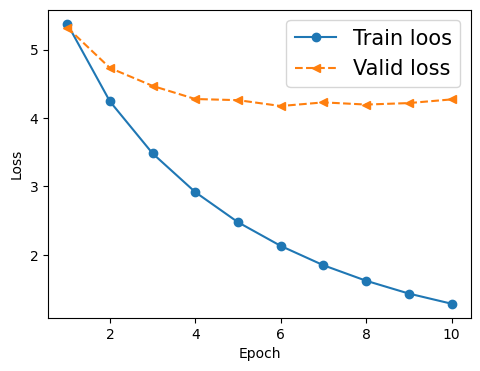

In [ ]:
x_arr = np.arange(len(train_loss_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_loss_history, "-o", label="Train loss")
ax.plot(x_arr, valid_loss_history, "--<", label="Valid loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=15)

#Evaluation

Loss here is derived from Cross Entropy (consider 'criterion' from previous cell). Perplexity is a metric that indicates how much "surprised" a model is when "seeing" new data. Perplexity is computed as the exponentiation of the loss produced by the model.

In [ ]:

if torch.cuda.is_available():
  model.load_state_dict(torch.load("gec-model_4_large.pt"))
else:
  model.load_state_dict(torch.load("gec-model_4_large.pt", map_location=torch.device("cpu")))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.206 | Test PPL: 182.371 |


Function for making inferences with the model



In [ ]:
def correct_sentence(
  sentence,
  model,
  en_vocab,
  lower,
  reverse,
  sos_token,
  eos_token,
  device,
  max_output_length=25,
):

  model.eval()

  with torch.no_grad():

    if isinstance(sentence, str):

      if reverse:
        tokens = sentence.split()[::-1]
      else:
        tokens = sentence.split()

    else:

      if reverse:
        tokens = [token for token in sentence][::-1]
      else:
        tokens = [token for token in sentence]

    if lower:

      tokens = [token.lower() for token in tokens]
      tokens = [sos_token] + tokens + [eos_token]
      ids = en_vocab.lookup_indices(tokens)
      tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
      hidden, cell = model.encoder(tensor)
      inputs = en_vocab.lookup_indices([sos_token])

      for _ in range(max_output_length):

        inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
        output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
        predicted_token = output.argmax(-1).item()
        inputs.append(predicted_token)

        if predicted_token == en_vocab[eos_token]:

            break

        tokens = en_vocab.lookup_tokens(inputs)

  return tokens

In [ ]:
sentence = test_data[2]["src"]
expected_correction = test_data[2]["tgt"]

sentence, expected_correction

('All professional boxers are at risk from being killed in his next fight .',
 'All professional boxers are at risk from being killed in their next fight .')

In [ ]:
correction = correct_sentence(
  sentence,
  model,
  en_vocab,
  lower,
  reverse,
  sos_token,
  eos_token,
  device
)

In [ ]:
correction

['<sos>',
 'all',
 'our',
 'movies',
 'are',
 'at',
 '6',
 ',',
 ',',
 'she',
 'works',
 'at',
 'a',
 'week',
 '.']

##Inference

The trained model is fed with the test data. The predictions with source and target sentences are stored at `test/model_name/`.

In [ ]:
ids = []
sentences = []
references = []
targets = []

model_name = "model_4"

os.makedirs(f"test/{model_name}", exist_ok=True)

for i in range(len(test_data)):
  sentence = test_data[i]["src"]
  expected_correction = test_data[i]["tgt"]
  correction = correct_sentence(
    sentence,
    model,
    en_vocab,
    lower,
    reverse,
    sos_token,
    eos_token,
    device
  )

  correction = " ".join([token for token in correction][1:])

  ids.append(i)
  sentences.append(sentence)
  references.append(expected_correction)
  targets.append(correction)

  with open(f"test/{model_name}/sources.txt", "a") as file:
    file.write(sentence + "\n")

  with open(f"test/{model_name}/references.txt", "a") as file:
    file.write(expected_correction + "\n")

  with open(f"test/{model_name}/targets.txt", "a") as file:
    file.write(correction + "\n")
